# Financial Text Classification Using FinBERT With Pytorch


In [1]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

"""
Sklearn Libraries
"""
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

"""
Transformer Libraries
"""
from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

"""
Pytorch Libraries
"""
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

In [2]:
torch.get_num_threads()

1

In [3]:
def show_headline_distribution(sequence_lengths, figsize = (15,8)):
    
    # Get the percentage of reviews with length > 512
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus)/len(sequence_lengths))*100
    
    print("Maximum Sequence Length is {}".format(max(sequence_lengths)))
    
    # Configure the plot size
    plt.figure(figsize = figsize)

    sns.set(style='darkgrid')
    
    # Increase information on the figure
    sns.set(font_scale=1.3)
    
    # Plot the result
    sns.distplot(sequence_lengths, kde = False, rug = False)
    plt.title('Headlines Lengths Distribution')
    plt.xlabel('Headlines Length')
    plt.ylabel('Number of Headlines')

In [4]:
financial_data = pd.read_csv("https://raw.githubusercontent.com/vrunm/nlp-datasets/main/all-data.csv", 
                             encoding='latin-1', 
                             names=['sentiment', 'NewsHeadline'])

In [5]:
financial_data.head()

,sentiment,NewsHeadline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
financial_data.shape

(4846, 2)

In [8]:
financial_data.sentiment.value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

In [9]:
def show_random_headlines(total_number, df):
    
    # Get the random number of reviews
    n_reviews = df.sample(total_number)
    
    # Print each one of the reviews
    for val in list(n_reviews.index):
        print("Reviews #°{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["sentiment"]))
        print(" - News Headline: {}".format(df.iloc[val]["NewsHeadline"]))
        print("")
        

In [10]:
# Show 3 random headlines
show_random_headlines(5, financial_data)

Reviews #°3857
 - Sentiment: neutral
 - News Headline: The group posted net sales of 35.3 mln euro $ 46.5 mln and an operating profit of 760,000 euro $ 1.0 mln in 2005 .

Reviews #°2877
 - Sentiment: neutral
 - News Headline: Elcoteq SE Stock Exchange Announcement February 4 , 2009 at 10.00 am ( EET ) Elcoteq will publish its financial statements bulletin 2008 on Wednesday , February 11 , at 9.00 am ( EET ) .

Reviews #°3812
 - Sentiment: neutral
 - News Headline: The contract is worth some EUR 1 million .

Reviews #°2585
 - Sentiment: neutral
 - News Headline: The aforementioned shareholders have informed that they will propose to the Annual General Meeting that the number of members of the Board of Directors shall be five and that besides the present members of the Board of Directors also Mr Lassi Noponen shall be elected to the Board of Directors .

Reviews #°4296
 - Sentiment: neutral
 - News Headline: `` The rest of this week 's tapings of Jimmy Kimmel Live have been canceled unti

Text(0, 0.5, 'Number of News')

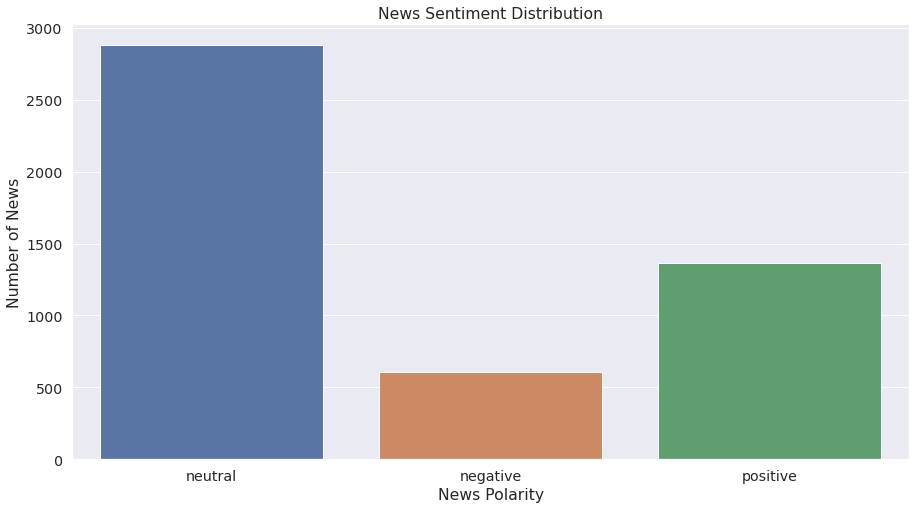

In [11]:
# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='sentiment', data = financial_data)
plt.title('News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

In [12]:
def get_headlines_len(df):
    
    headlines_sequence_lengths = []
    
    print("Encoding in progress...")
    for headline in tqdm(df.NewsHeadline):
        encoded_headline = finbert_tokenizer.encode(headline, 
                                         add_special_tokens = True)
        
        # record the length of the encoded review
        headlines_sequence_lengths.append(len(encoded_headline))
    print("End of Task.")
    
    return headlines_sequence_lengths

## Data Preparation

In [13]:
def encode_sentiments_values(df):
    
    possible_sentiments = df.sentiment.unique()
    sentiment_dict = {}
    
    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index
    
    # Encode all the sentiment values
    df['label'] = df.sentiment.replace(sentiment_dict)
    
    return df, sentiment_dict

In [14]:
# Encode the sentiment column
financial_data, sentiment_dict = encode_sentiments_values(financial_data)

financial_data.head()

,sentiment,NewsHeadline,label
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,1
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


In [15]:
# Create training and validation data
X_train, X_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

In [16]:
# Create the data type columns
financial_data.loc[X_train, 'data_type'] = 'train'
financial_data.loc[X_val, 'data_type'] = 'val'

# Visualize the number of sentiment occurence on each type of data
financial_data.groupby(['sentiment', 'label', 'data_type']).count()

NewsHeadline
sentiment label data_type              
negative  1     train               513
                val                  91
neutral   0     train              2447
                val                 432
positive  2     train              1159
                val                 204

In [17]:
# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", 
                                          do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 )

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 )


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
len(sentiment_dict)

3

In [19]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [20]:
headlines_sequence_lengths = get_headlines_len(financial_data)

Encoding in progress...


100%|██████████| 4846/4846 [00:03<00:00, 1305.74it/s]

End of Task.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Maximum Sequence Length is 150


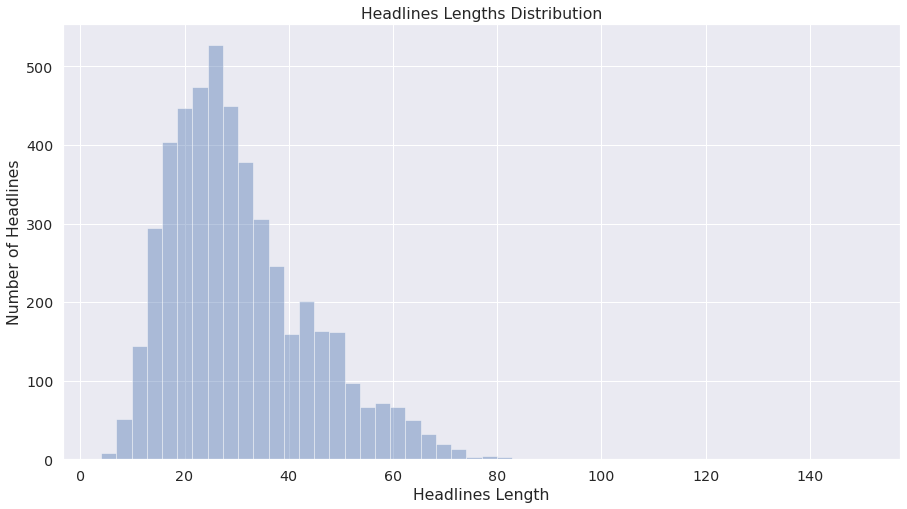

In [21]:
'''
# Show the reviews distribution 
The overall implementation of this function is in my notebook at end of the article
'''
show_headline_distribution(headlines_sequence_lengths)

In [22]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [23]:
optimizer1 = torch.optim.AdamW(model.parameters(),
                  lr=5e-5, 
                  eps=1e-8)
optimizer2 = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer3 = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.001)
optimizer4 = torch.optim.RMSprop(model.parameters(),lr=0.01, alpha=0.99, eps=1e-08, momentum=0.01)
optimizer5 = torch.optim.Adagrad(model.parameters(),lr=0.01, lr_decay=0, weight_decay=0)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [24]:
seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals, loss_values = [], [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        loss_values.append(loss)
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)    
    return loss_val_avg, predictions, true_vals


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer2.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals, loss_values = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [01:00<?, ?it/s]                                          


Epoch 1
Training loss: 0.4715809278594431


  0%|          | 0/3 [01:04<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    acc = []
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        acc.append((len(y_preds[y_preds==label])) / (len(y_true)))
    print("Model Accuracy: ", np.mean(acc)*100)
    


In [ ]:
def accuracy(preds,labels):  
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    acc = []
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(y_preds)
        print(y_true)
        #print(f'Accuracy: {(y_preds[y_preds==label])}/{len(y_preds)}\n')

In [ ]:
# Load the best model & Make Predictions

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_finBERT_epoch_1.model', 
                                 map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)
accuracy(predictions, true_vals)

In [ ]:
#Plotting Accuracy vs epoch
import matplotlib as plt
plt.plot(accuracy_per_class,epochs)